### Load in time series objects of the Twitter, Google search, and FBI Hate-Crime datasets

Granger causality is based on the idea that if a variable X can be used to predict another variable Y better than Y can be predicted by its own past values, then X is said to Granger-cause Y. However, this does not necessarily mean that X causes Y in the sense of a direct causal relationship. 

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt

In [2]:
twitter_d = pd.read_csv('/Users/itsyuzhou/Spring2023/MACS30200/replication-materials-yuzhouw313/time series/ts_day_tweet.csv', index_col=0, parse_dates=True)
twitter_w = pd.read_csv('/Users/itsyuzhou/Spring2023/MACS30200/replication-materials-yuzhouw313/time series/ts_week_tweet.csv', index_col=0, parse_dates=True)
google_d_old = pd.read_csv('/Users/itsyuzhou/Spring2023/MACS30200/replication-materials-yuzhouw313/time series/ts_day_google_old.csv', index_col=0, parse_dates=True)
google_d_new = pd.read_csv('/Users/itsyuzhou/Spring2023/MACS30200/replication-materials-yuzhouw313/time series/ts_day_google_new.csv', index_col=0, parse_dates=True)
google_w_old = pd.read_csv('/Users/itsyuzhou/Spring2023/MACS30200/replication-materials-yuzhouw313/time series/ts_week_google_old.csv', index_col=0, parse_dates=True)
google_w_new = pd.read_csv('/Users/itsyuzhou/Spring2023/MACS30200/replication-materials-yuzhouw313/time series/ts_week_google_new.csv', index_col=0, parse_dates=True)
crime_w = pd.read_csv('/Users/itsyuzhou/Spring2023/MACS30200/replication-materials-yuzhouw313/time series/ts_week_crime.csv', index_col=0, parse_dates=True)

In [3]:
def granger_table(res, lag_val):
    ''' 
    Helper function to write out and organize p-values for different tests on different lag values
    Input: The result for Granger Causality test from the previous step
    '''
    table = pd.DataFrame(columns=['Maxlags', 'ssr F p-value', 'ssr chi2 p-value', 
                                 'likelihoodratio p-value', 'param F p-value'])

    for lag in range(1, lag_val+1):
        test_results = res[lag][0]
        table = table.append({'Maxlags': lag, 
                                        'ssr F p-value': round(test_results['ssr_ftest'][1], 3),
                                        'ssr chi2 p-value': round(test_results['ssr_chi2test'][1], 3),
                                        'likelihoodratio p-value': round(test_results['lrtest'][1], 3),
                                        'param F p-value': round(test_results['params_ftest'][1], 3)},
                                        ignore_index=True)
    return table

## Granger Causality for daily Twitter and Google Search Time Series

### Create new time series of differenced daily Twitter, Google old, and Google new data

Since the daily Twitter time series is non-stationary while both of the daily Google search time series (traditional Sinophobic terms and covid-related Sinophobic terms), need to difference both the former and the latter for consistency

In [3]:
twitter_d_diff = twitter_d.diff().dropna()
google_d_old_diff = google_d_old.diff().dropna()
google_d_new_diff = google_d_new.diff().dropna()

In [4]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(twitter_d_diff)

print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print('The daily twitter time series is stationary.')
else:
    print('The daily twitter time series is non-stationary.')

ADF Statistic: -8.507515124649213
p-value: 1.1917865939011757e-13
The daily twitter time series is stationary.


In [8]:
daily_data = pd.concat([twitter_d_diff, google_d_old_diff, google_d_new_diff], axis=1)
daily_data = daily_data.set_axis(['twitter', 'google_old', 'google_new'], axis=1)
daily_data

,twitter,google_old,google_new
2020-01-02,103.0,1.0,0.5
2020-01-03,148.0,-18.0,0.0
2020-01-04,-89.0,0.0,0.0
2020-01-05,-108.0,-6.0,0.0
2020-01-06,-30.0,10.0,0.5
...,...,...,...
2020-12-27,88.0,-19.0,3.0
2020-12-28,-31.0,27.0,-2.0
2020-12-29,12.0,21.0,3.0
2020-12-30,-27.0,-16.0,1.0


### Plotting the stationary daily data

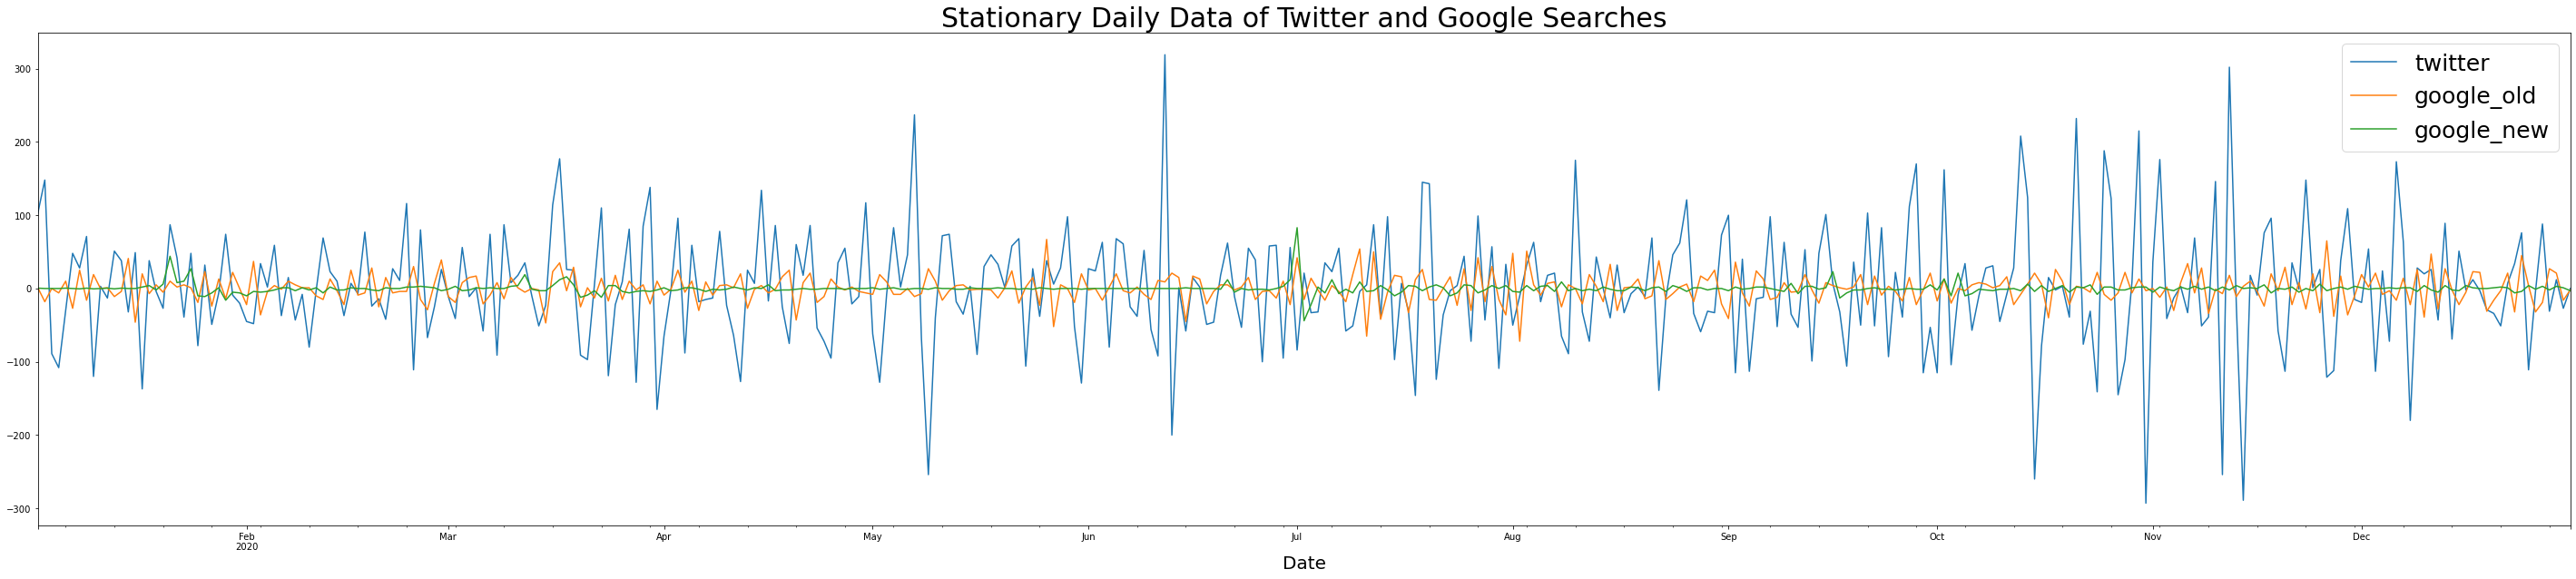

In [14]:
daily_data.plot(figsize=(50, 10))
plt.xlabel('Date', fontsize=20)
plt.title('Stationary Daily Data of Twitter and Google Searches', fontsize=30)
plt.legend(fontsize=25)

### Vector autoregressive (VAR) modelling

In [15]:
# Create a VAR model

from statsmodels.tsa.api import VAR
model = VAR(daily_data)

/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


- AIC = Akaike Information Criterion
- BIC = Bayesian Information Criterion
- FPE = Final Prediction Error
- HQIC = Hannan-Quinn Criterion

In [16]:
# Selecting the Lag Order:
order = model.select_order()
order.summary()

,AIC,BIC,FPE,HQIC
0,18.80,18.84,1.465e+08,18.82
1,18.48,18.61,1.057e+08,18.53
2,18.34,18.57*,9.194e+07,18.43
3,18.26,18.59,8.474e+07,18.39
4,18.21,18.64,8.125e+07,18.38
5,18.15,18.69,7.665e+07,18.37
6,18.04*,18.67,6.851e+07*,18.29*
7,18.06,18.79,6.973e+07,18.35
8,18.08,18.91,7.110e+07,18.41
9,18.07,19.00,7.054e+07,18.44


Based on the minimum values of the above criterion, the most appropriate lag order is 6

In [26]:
# Fit the VAR model, returns the Estimation results
estimation_results = model.fit(6)
# Summarize the results and perform Granger Causality tests
estimation_results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, May, 2023
Time:                     22:14:03
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    18.6039
Nobs:                     359.000    HQIC:                   18.2325
Log likelihood:          -4699.92    FPE:                6.48511e+07
AIC:                      17.9873    Det(Omega_mle):     5.55553e+07
--------------------------------------------------------------------
Results for equation twitter
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.618284         3.747552            0.165           0.869
L1.twitter           -0.523967         0.053076           -9.872           0.000
L1.google_old         0.047715         0.249301           

In [39]:
from statsmodels.tsa.stattools import grangercausalitytests

results = grangercausalitytests(daily_data[['twitter', 'google_old']], maxlag=30, verbose=False)
for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")

Lag 1
	F-Statistic: 0.0801, p-value: 0.7773
Lag 2
	F-Statistic: 0.7190, p-value: 0.4879
Lag 3
	F-Statistic: 1.2032, p-value: 0.3085
Lag 4
	F-Statistic: 0.7831, p-value: 0.5367
Lag 5
	F-Statistic: 0.5197, p-value: 0.7614
Lag 6
	F-Statistic: 0.6711, p-value: 0.6731
Lag 7
	F-Statistic: 0.6827, p-value: 0.6867
Lag 8
	F-Statistic: 0.6106, p-value: 0.7690
Lag 9
	F-Statistic: 1.1579, p-value: 0.3214
Lag 10
	F-Statistic: 1.0696, p-value: 0.3851
Lag 11
	F-Statistic: 0.9803, p-value: 0.4640
Lag 12
	F-Statistic: 0.8141, p-value: 0.6359
Lag 13
	F-Statistic: 0.7893, p-value: 0.6715
Lag 14
	F-Statistic: 0.7430, p-value: 0.7304
Lag 15
	F-Statistic: 0.7683, p-value: 0.7127
Lag 16
	F-Statistic: 0.7179, p-value: 0.7756
Lag 17
	F-Statistic: 0.8824, p-value: 0.5955
Lag 18
	F-Statistic: 0.9956, p-value: 0.4644
Lag 19
	F-Statistic: 1.0882, p-value: 0.3618
Lag 20
	F-Statistic: 1.0280, p-value: 0.4285
Lag 21
	F-Statistic: 1.1656, p-value: 0.2803
Lag 22
	F-Statistic: 1.0696, p-value: 0.3795
Lag 23
	F-Statistic

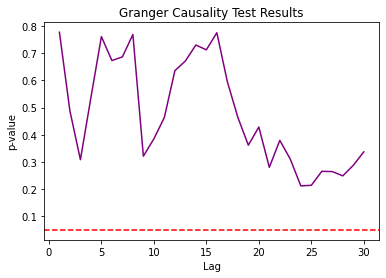

In [40]:
p_values = [test_results[0]['params_ftest'][1] for lag, test_results in results.items()]

fig, ax = plt.subplots()
ax.plot(range(1, len(p_values)+1), p_values, color='purple')
ax.axhline(y=0.05, color='red', linestyle='--')
ax.set_xlabel('Lag')
ax.set_ylabel('p-value')
ax.set_title('Granger Causality Test Results')
plt.show()

In [41]:
results = grangercausalitytests(daily_data[['twitter', 'google_new']], maxlag=30, verbose=False)
for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")

Lag 1
	F-Statistic: 0.0092, p-value: 0.9238
Lag 2
	F-Statistic: 0.1291, p-value: 0.8790
Lag 3
	F-Statistic: 0.4741, p-value: 0.7005
Lag 4
	F-Statistic: 0.5438, p-value: 0.7037
Lag 5
	F-Statistic: 0.4046, p-value: 0.8455
Lag 6
	F-Statistic: 0.3311, p-value: 0.9204
Lag 7
	F-Statistic: 0.5398, p-value: 0.8042
Lag 8
	F-Statistic: 0.4876, p-value: 0.8649
Lag 9
	F-Statistic: 0.4324, p-value: 0.9173
Lag 10
	F-Statistic: 0.4067, p-value: 0.9431
Lag 11
	F-Statistic: 0.4274, p-value: 0.9435
Lag 12
	F-Statistic: 0.4252, p-value: 0.9531
Lag 13
	F-Statistic: 0.4976, p-value: 0.9255
Lag 14
	F-Statistic: 0.5182, p-value: 0.9222
Lag 15
	F-Statistic: 0.4956, p-value: 0.9423
Lag 16
	F-Statistic: 0.4912, p-value: 0.9508
Lag 17
	F-Statistic: 0.6478, p-value: 0.8523
Lag 18
	F-Statistic: 0.6640, p-value: 0.8459
Lag 19
	F-Statistic: 0.6678, p-value: 0.8499
Lag 20
	F-Statistic: 0.8313, p-value: 0.6749
Lag 21
	F-Statistic: 0.7314, p-value: 0.7998
Lag 22
	F-Statistic: 0.6979, p-value: 0.8414
Lag 23
	F-Statistic

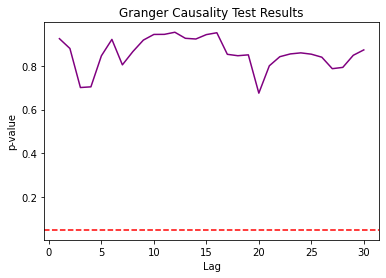

In [42]:
p_values = [test_results[0]['params_ftest'][1] for lag, test_results in results.items()]

fig, ax = plt.subplots()
ax.plot(range(1, len(p_values)+1), p_values, color='purple')
ax.axhline(y=0.05, color='red', linestyle='--')
ax.set_xlabel('Lag')
ax.set_ylabel('p-value')
ax.set_title('Granger Causality Test Results')
plt.show()

In [43]:
results = grangercausalitytests(daily_data[['google_old', 'twitter']], maxlag=30, verbose=False)
for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")

Lag 1
	F-Statistic: 2.6776, p-value: 0.1026
Lag 2
	F-Statistic: 3.2192, p-value: 0.0411
Lag 3
	F-Statistic: 2.5287, p-value: 0.0571
Lag 4
	F-Statistic: 2.0214, p-value: 0.0910
Lag 5
	F-Statistic: 2.3438, p-value: 0.0411
Lag 6
	F-Statistic: 1.9343, p-value: 0.0746
Lag 7
	F-Statistic: 1.8278, p-value: 0.0810
Lag 8
	F-Statistic: 1.6628, p-value: 0.1063
Lag 9
	F-Statistic: 1.5373, p-value: 0.1334
Lag 10
	F-Statistic: 1.4075, p-value: 0.1753
Lag 11
	F-Statistic: 1.2907, p-value: 0.2281
Lag 12
	F-Statistic: 1.3069, p-value: 0.2127
Lag 13
	F-Statistic: 1.2415, p-value: 0.2483
Lag 14
	F-Statistic: 1.1863, p-value: 0.2842
Lag 15
	F-Statistic: 1.1873, p-value: 0.2799
Lag 16
	F-Statistic: 1.1240, p-value: 0.3313
Lag 17
	F-Statistic: 1.1574, p-value: 0.2987
Lag 18
	F-Statistic: 1.0561, p-value: 0.3967
Lag 19
	F-Statistic: 1.1772, p-value: 0.2753
Lag 20
	F-Statistic: 1.1287, p-value: 0.3186
Lag 21
	F-Statistic: 1.1123, p-value: 0.3335
Lag 22
	F-Statistic: 1.1589, p-value: 0.2841
Lag 23
	F-Statistic

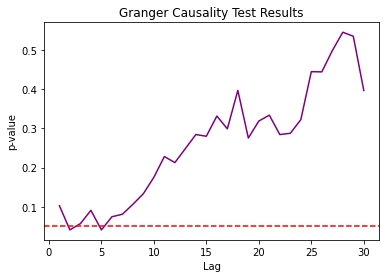

In [44]:
p_values = [test_results[0]['params_ftest'][1] for lag, test_results in results.items()]

fig, ax = plt.subplots()
ax.plot(range(1, len(p_values)+1), p_values, color='purple')
ax.axhline(y=0.05, color='red', linestyle='--')
ax.set_xlabel('Lag')
ax.set_ylabel('p-value')
ax.set_title('Granger Causality Test Results')
plt.show()

In [45]:
results = grangercausalitytests(daily_data[['google_new', 'twitter']], maxlag=50, verbose=False)
for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")

Lag 1
	F-Statistic: 1.6974, p-value: 0.1935
Lag 2
	F-Statistic: 1.1637, p-value: 0.3135
Lag 3
	F-Statistic: 0.8726, p-value: 0.4554
Lag 4
	F-Statistic: 0.6095, p-value: 0.6560
Lag 5
	F-Statistic: 0.7109, p-value: 0.6156
Lag 6
	F-Statistic: 0.6113, p-value: 0.7213
Lag 7
	F-Statistic: 0.6018, p-value: 0.7544
Lag 8
	F-Statistic: 0.7157, p-value: 0.6777
Lag 9
	F-Statistic: 0.8505, p-value: 0.5700
Lag 10
	F-Statistic: 0.7850, p-value: 0.6434
Lag 11
	F-Statistic: 0.7029, p-value: 0.7359
Lag 12
	F-Statistic: 0.6401, p-value: 0.8075
Lag 13
	F-Statistic: 0.6205, p-value: 0.8369
Lag 14
	F-Statistic: 0.7155, p-value: 0.7588
Lag 15
	F-Statistic: 0.7130, p-value: 0.7713
Lag 16
	F-Statistic: 0.8283, p-value: 0.6531
Lag 17
	F-Statistic: 0.8652, p-value: 0.6160
Lag 18
	F-Statistic: 0.9338, p-value: 0.5378
Lag 19
	F-Statistic: 1.2725, p-value: 0.1997
Lag 20
	F-Statistic: 1.3185, p-value: 0.1649
Lag 21
	F-Statistic: 1.1764, p-value: 0.2703
Lag 22
	F-Statistic: 1.2082, p-value: 0.2389
Lag 23
	F-Statistic

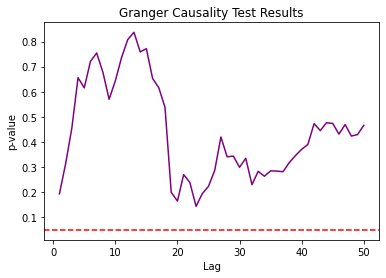

In [46]:
p_values = [test_results[0]['params_ftest'][1] for lag, test_results in results.items()]

fig, ax = plt.subplots()
ax.plot(range(1, len(p_values)+1), p_values, color='purple')
ax.axhline(y=0.05, color='red', linestyle='--')
ax.set_xlabel('Lag')
ax.set_ylabel('p-value')
ax.set_title('Granger Causality Test Results')
plt.show()

Daily VAR model and Granger Causality Results:
- The change in the use of Sinophobic words on Twitter doesn't correlate with the change in the search of traditional Sinophobic words on Google
- The change in the use of Sinophobic words on Twitter doesn't correlate with the change in the search of newly covid-related Sinophobic words on Google
- The change in the search of newly covid-related Sinophobic words on Google doesn't correlate with the change in the use of Sinophobic words on Twitter
- The change in the search of newly covid-related Sinophobic words on Google correlate with the change in the use of Sinophobic words on Twitter at lag 2 and 5


Test whether twitter_d_df Granger causes google_d_old_df, i.e., whether daily Twitter trend can predict (Granger Cause) daily Google search trend

In [6]:
tg_res1 = grangercausalitytests(np.column_stack((twitter_d_df, google_d_old_df)), maxlag=30)
tg_res1


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0801  , p=0.7773  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=0.0807  , p=0.7763  , df=1
likelihood ratio test: chi2=0.0807  , p=0.7763  , df=1
parameter F test:         F=0.0801  , p=0.7773  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7190  , p=0.4879  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=1.4581  , p=0.4824  , df=2
likelihood ratio test: chi2=1.4551  , p=0.4831  , df=2
parameter F test:         F=0.7190  , p=0.4879  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2032  , p=0.3085  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=3.6807  , p=0.2981  , df=3
likelihood ratio test: chi2=3.6622  , p=0.3003  , df=3
parameter F test:         F=1.2032  , p=0.3085  , df_denom=355, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.7831  , p=0.5367  

{1: ({'ssr_ftest': (0.08008291243441992, 0.7773472814931969, 361.0, 1),
   'ssr_chi2test': (0.08074842140201897, 0.7762857239331737, 1),
   'lrtest': (0.08073946625972894, 0.7762977991309631, 1),
   'params_ftest': (0.08008291243422452, 0.7773472814934139, 361.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.7189893185691056, 0.48794665559057704, 358.0, 2),
   'ssr_chi2test': (1.4580621376569016, 0.4823761530203644, 2),
   'lrtest': (1.455141656339947, 0.4830810528281094, 2),
   'params_ftest': (0.7189893185690943, 0.48794665559057704, 358.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.203189443639137, 0.30847426248363147, 355.0, 3),
   'ssr_chi2test': (3.6807429177242335, 0.2980657838387976, 3),
   'lrtest': (3.6621562762411486, 0.3003319159157183, 3),
   'params_ftest': (1.2031894436391168, 0.3084742624836439, 355.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0.,

In [7]:
tg_table = granger_table(tg_res1, 30) 
tg_table

/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.appe

,Maxlags,ssr F p-value,ssr chi2 p-value,likelihoodratio p-value,param F p-value
0,1.0,0.777,0.776,0.776,0.777
1,2.0,0.488,0.482,0.483,0.488
2,3.0,0.308,0.298,0.3,0.308
3,4.0,0.537,0.523,0.525,0.537
4,5.0,0.761,0.749,0.751,0.761
5,6.0,0.673,0.653,0.656,0.673
6,7.0,0.687,0.661,0.666,0.687
7,8.0,0.769,0.744,0.748,0.769
8,9.0,0.321,0.275,0.287,0.321
9,10.0,0.385,0.33,0.343,0.385


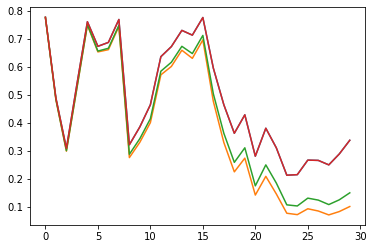

In [52]:
plt.plot(tg_table.index, tg_table['ssr F p-value'])
plt.plot(tg_table.index, tg_table['ssr chi2 p-value'])
plt.plot(tg_table.index, tg_table['likelihoodratio p-value'])
plt.plot(tg_table.index, tg_table['param F p-value'])

- Conclusion: twitter_d_df doesn't Granger-cause  google_d_old_df

In [8]:
tg_res2 = grangercausalitytests(np.column_stack((twitter_d_df, google_d_new_df)), maxlag=30)
tg_table2 = granger_table(tg_res2, 30) 
tg_table2


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0092  , p=0.9238  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=0.0092  , p=0.9235  , df=1
likelihood ratio test: chi2=0.0092  , p=0.9235  , df=1
parameter F test:         F=0.0092  , p=0.9238  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1291  , p=0.8790  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=0.2617  , p=0.8773  , df=2
likelihood ratio test: chi2=0.2616  , p=0.8774  , df=2
parameter F test:         F=0.1291  , p=0.8790  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.4741  , p=0.7005  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=1.4502  , p=0.6938  , df=3
likelihood ratio test: chi2=1.4473  , p=0.6945  , df=3
parameter F test:         F=0.4741  , p=0.7005  , df_denom=355, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5438  , p=0.7037  

/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.appe

,Maxlags,ssr F p-value,ssr chi2 p-value,likelihoodratio p-value,param F p-value
0,1.0,0.924,0.923,0.923,0.924
1,2.0,0.879,0.877,0.877,0.879
2,3.0,0.701,0.694,0.694,0.701
3,4.0,0.704,0.693,0.695,0.704
4,5.0,0.846,0.837,0.838,0.846
5,6.0,0.92,0.914,0.915,0.92
6,7.0,0.804,0.786,0.789,0.804
7,8.0,0.865,0.848,0.851,0.865
8,9.0,0.917,0.904,0.906,0.917
9,10.0,0.943,0.932,0.933,0.943


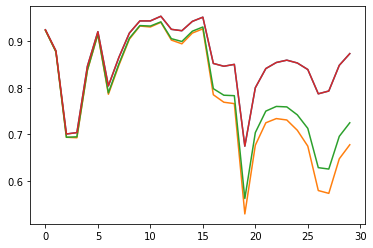

In [53]:
plt.plot(tg_table2.index, tg_table2['ssr F p-value'])
plt.plot(tg_table2.index, tg_table2['ssr chi2 p-value'])
plt.plot(tg_table2.index, tg_table2['likelihoodratio p-value'])
plt.plot(tg_table2.index, tg_table2['param F p-value'])

- Conclusion: twitter_d_df doesn't Granger-cause google_d_new_df

In [9]:
gt_res1 = grangercausalitytests(np.column_stack((google_d_old_df, twitter_d_df)), maxlag=30)
gt_table1 = granger_table(gt_res1, 30) 
gt_table1


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6776  , p=0.1026  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=2.6998  , p=0.1004  , df=1
likelihood ratio test: chi2=2.6898  , p=0.1010  , df=1
parameter F test:         F=2.6776  , p=0.1026  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2192  , p=0.0411  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=6.5284  , p=0.0382  , df=2
likelihood ratio test: chi2=6.4704  , p=0.0394  , df=2
parameter F test:         F=3.2192  , p=0.0411  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.5287  , p=0.0571  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=7.7357  , p=0.0518  , df=3
likelihood ratio test: chi2=7.6542  , p=0.0537  , df=3
parameter F test:         F=2.5287  , p=0.0571  , df_denom=355, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0214  , p=0.0910  

/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.appe

,Maxlags,ssr F p-value,ssr chi2 p-value,likelihoodratio p-value,param F p-value
0,1.0,0.103,0.1,0.101,0.103
1,2.0,0.041,0.038,0.039,0.041
2,3.0,0.057,0.052,0.054,0.057
3,4.0,0.091,0.081,0.085,0.091
4,5.0,0.041,0.034,0.036,0.041
5,6.0,0.075,0.061,0.066,0.075
6,7.0,0.081,0.064,0.069,0.081
7,8.0,0.106,0.083,0.09,0.106
8,9.0,0.133,0.102,0.111,0.133
9,10.0,0.175,0.134,0.145,0.175


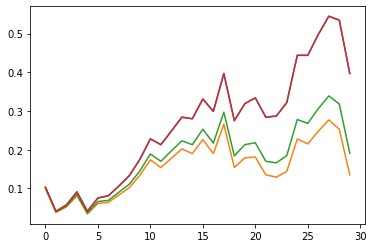

In [54]:
plt.plot(gt_table1.index, gt_table1['ssr F p-value'])
plt.plot(gt_table1.index, gt_table1['ssr chi2 p-value'])
plt.plot(gt_table1.index, gt_table1['likelihoodratio p-value'])
plt.plot(gt_table1.index, gt_table1['param F p-value'])

- Conclusion: Observe from the above Granger Causality Result Table, we see the p-values are significant at lag=2 and lag=5, which suggests the possibility of a causal relationship between the two variables being tested.

In [10]:
gt_res2 = grangercausalitytests(np.column_stack((google_d_new_df, twitter_d_df)), maxlag=30)
gt_table2 = granger_table(gt_res2, 30) 
gt_table2


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6974  , p=0.1935  , df_denom=361, df_num=1
ssr based chi2 test:   chi2=1.7115  , p=0.1908  , df=1
likelihood ratio test: chi2=1.7075  , p=0.1913  , df=1
parameter F test:         F=1.6974  , p=0.1935  , df_denom=361, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1637  , p=0.3135  , df_denom=358, df_num=2
ssr based chi2 test:   chi2=2.3598  , p=0.3073  , df=2
likelihood ratio test: chi2=2.3522  , p=0.3085  , df=2
parameter F test:         F=1.1637  , p=0.3135  , df_denom=358, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.8726  , p=0.4554  , df_denom=355, df_num=3
ssr based chi2 test:   chi2=2.6695  , p=0.4454  , df=3
likelihood ratio test: chi2=2.6597  , p=0.4471  , df=3
parameter F test:         F=0.8726  , p=0.4554  , df_denom=355, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6095  , p=0.6560  

/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.appe

,Maxlags,ssr F p-value,ssr chi2 p-value,likelihoodratio p-value,param F p-value
0,1.0,0.193,0.191,0.191,0.193
1,2.0,0.314,0.307,0.308,0.314
2,3.0,0.455,0.445,0.447,0.455
3,4.0,0.656,0.645,0.646,0.656
4,5.0,0.616,0.598,0.601,0.616
5,6.0,0.721,0.703,0.706,0.721
6,7.0,0.754,0.733,0.736,0.754
7,8.0,0.678,0.646,0.652,0.678
8,9.0,0.57,0.525,0.535,0.57
9,10.0,0.643,0.595,0.605,0.643


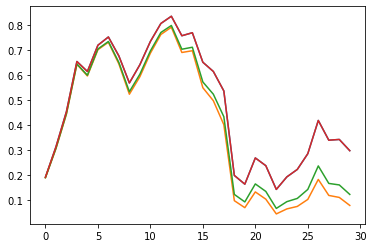

In [55]:
plt.plot(gt_table2.index, gt_table2['ssr F p-value'])
plt.plot(gt_table2.index, gt_table2['ssr chi2 p-value'])
plt.plot(gt_table2.index, gt_table2['likelihoodratio p-value'])
plt.plot(gt_table2.index, gt_table2['param F p-value'])

- Conclusion: google_d_new_df doesn't Granger-cause twitter_d_df

## Granger Causality for Monthly Twitter and Google Search Time Series

In [11]:
google_m_old_df = google_m_old.diff().dropna()
google_m_new_df = google_m_new.diff().dropna()

In [12]:
tgm_res1 = grangercausalitytests(np.column_stack((twitter_m_df, google_m_old_df)), maxlag=3)
tgm_table1 = granger_table(tgm_res1, 3)
tgm_table1


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6530  , p=0.1474  , df_denom=7, df_num=1
ssr based chi2 test:   chi2=3.7900  , p=0.0516  , df=1
likelihood ratio test: chi2=3.2136  , p=0.0730  , df=1
parameter F test:         F=2.6530  , p=0.1474  , df_denom=7, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3707  , p=0.7117  , df_denom=4, df_num=2
ssr based chi2 test:   chi2=1.6682  , p=0.4343  , df=2
likelihood ratio test: chi2=1.5304  , p=0.4652  , df=2
parameter F test:         F=0.3707  , p=0.7117  , df_denom=4, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1334  , p=0.5831  , df_denom=1, df_num=3
ssr based chi2 test:   chi2=27.2018 , p=0.0000  , df=3
likelihood ratio test: chi2=11.8533 , p=0.0079  , df=3
parameter F test:         F=1.1334  , p=0.5831  , df_denom=1, df_num=3


/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,


,Maxlags,ssr F p-value,ssr chi2 p-value,likelihoodratio p-value,param F p-value
0,1.0,0.147,0.052,0.073,0.147
1,2.0,0.712,0.434,0.465,0.712
2,3.0,0.583,0.0,0.008,0.583


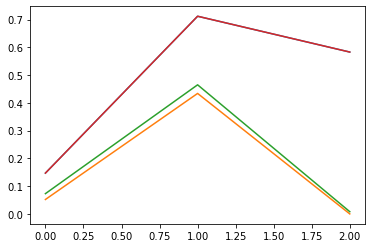

In [56]:
plt.plot(tgm_table1.index, tgm_table1['ssr F p-value'])
plt.plot(tgm_table1.index, tgm_table1['ssr chi2 p-value'])
plt.plot(tgm_table1.index, tgm_table1['likelihoodratio p-value'])
plt.plot(tgm_table1.index, tgm_table1['param F p-value'])

- Conclusion: At lag=3, we see significant p-value for SSR Chi2 Test and Likelihood Ratio Test. This indicates that Granger causality may exist between the two time series at a lag of 3 based on the likelihood ratio test and SSR based Chi2 test, i.e., Monthly Google Search Trend based on the old set of keywords may Granger-cause Monthly Tweitter Trend

In [13]:
tgm_res2 = grangercausalitytests(np.column_stack((twitter_m_df, google_m_new_df)), maxlag=3)
tgm_table2 = granger_table(tgm_res2, 3)
tgm_table2


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2116  , p=0.3074  , df_denom=7, df_num=1
ssr based chi2 test:   chi2=1.7308  , p=0.1883  , df=1
likelihood ratio test: chi2=1.5964  , p=0.2064  , df=1
parameter F test:         F=1.2116  , p=0.3074  , df_denom=7, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0499  , p=0.4300  , df_denom=4, df_num=2
ssr based chi2 test:   chi2=4.7247  , p=0.0942  , df=2
likelihood ratio test: chi2=3.7978  , p=0.1497  , df=2
parameter F test:         F=1.0499  , p=0.4300  , df_denom=4, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.0094  , p=0.2893  , df_denom=1, df_num=3
ssr based chi2 test:   chi2=144.2253, p=0.0000  , df=3
likelihood ratio test: chi2=23.5674 , p=0.0000  , df=3
parameter F test:         F=6.0094  , p=0.2893  , df_denom=1, df_num=3


/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,


,Maxlags,ssr F p-value,ssr chi2 p-value,likelihoodratio p-value,param F p-value
0,1.0,0.307,0.188,0.206,0.307
1,2.0,0.43,0.094,0.15,0.43
2,3.0,0.289,0.0,0.0,0.289


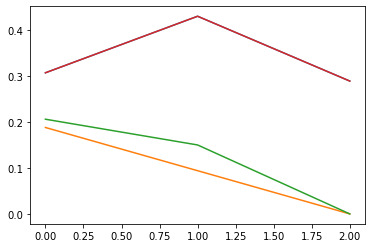

In [57]:
plt.plot(tgm_table2.index, tgm_table2['ssr F p-value'])
plt.plot(tgm_table2.index, tgm_table2['ssr chi2 p-value'])
plt.plot(tgm_table2.index, tgm_table2['likelihoodratio p-value'])
plt.plot(tgm_table2.index, tgm_table2['param F p-value'])

- Conclusion: Similarly at lag=3, we see significant p-value for SSR Chi2 Test and Likelihood Ratio Test. This indicates that Granger causality may exist between the two time series at a lag of 3 based on the likelihood ratio test and SSR based Chi2 test, i.e., Monthly Google Search Trend based on the new set of search words may Granger-cause Monthly Twitter Trend

In [14]:
gtm_res1 = grangercausalitytests(np.column_stack((google_m_old_df, twitter_m_df)), maxlag=3)
gtm_table1 = granger_table(gtm_res1, 3)
gtm_table1


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0066  , p=0.9377  , df_denom=7, df_num=1
ssr based chi2 test:   chi2=0.0094  , p=0.9229  , df=1
likelihood ratio test: chi2=0.0094  , p=0.9229  , df=1
parameter F test:         F=0.0066  , p=0.9377  , df_denom=7, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1676  , p=0.8513  , df_denom=4, df_num=2
ssr based chi2 test:   chi2=0.7543  , p=0.6858  , df=2
likelihood ratio test: chi2=0.7243  , p=0.6962  , df=2
parameter F test:         F=0.1676  , p=0.8513  , df_denom=4, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3237  , p=0.8229  , df_denom=1, df_num=3
ssr based chi2 test:   chi2=7.7700  , p=0.0510  , df=3
likelihood ratio test: chi2=5.4293  , p=0.1429  , df=3
parameter F test:         F=0.3237  , p=0.8229  , df_denom=1, df_num=3


/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,


,Maxlags,ssr F p-value,ssr chi2 p-value,likelihoodratio p-value,param F p-value
0,1.0,0.938,0.923,0.923,0.938
1,2.0,0.851,0.686,0.696,0.851
2,3.0,0.823,0.051,0.143,0.823


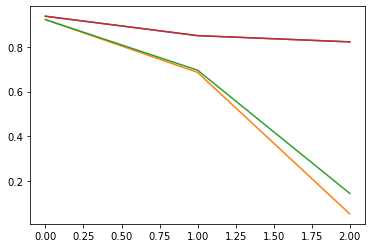

In [58]:
plt.plot(gtm_table1.index, gtm_table1['ssr F p-value'])
plt.plot(gtm_table1.index, gtm_table1['ssr chi2 p-value'])
plt.plot(gtm_table1.index, gtm_table1['likelihoodratio p-value'])
plt.plot(gtm_table1.index, gtm_table1['param F p-value'])

- Conclusion: There doesn't seem to be clear Granger Causality

In [15]:
gtm_res2 = grangercausalitytests(np.column_stack((google_m_new_df, twitter_m_df)), maxlag=3)
gtm_table2 = granger_table(gtm_res2, 3)
gtm_table2


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2302  , p=0.6460  , df_denom=7, df_num=1
ssr based chi2 test:   chi2=0.3289  , p=0.5663  , df=1
likelihood ratio test: chi2=0.3236  , p=0.5695  , df=1
parameter F test:         F=0.2302  , p=0.6460  , df_denom=7, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1097  , p=0.8987  , df_denom=4, df_num=2
ssr based chi2 test:   chi2=0.4938  , p=0.7812  , df=2
likelihood ratio test: chi2=0.4807  , p=0.7863  , df=2
parameter F test:         F=0.1097  , p=0.8987  , df_denom=4, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9525  , p=0.3986  , df_denom=1, df_num=3
ssr based chi2 test:   chi2=70.8592 , p=0.0000  , df=3
likelihood ratio test: chi2=18.3058 , p=0.0004  , df=3
parameter F test:         F=2.9525  , p=0.3986  , df_denom=1, df_num=3


/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,


,Maxlags,ssr F p-value,ssr chi2 p-value,likelihoodratio p-value,param F p-value
0,1.0,0.646,0.566,0.569,0.646
1,2.0,0.899,0.781,0.786,0.899
2,3.0,0.399,0.0,0.0,0.399


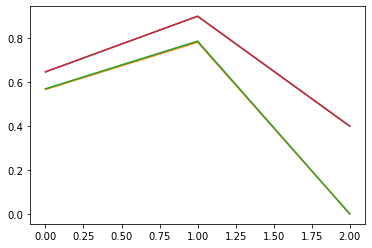

In [59]:
plt.plot(gtm_table2.index, gtm_table2['ssr F p-value'])
plt.plot(gtm_table2.index, gtm_table2['ssr chi2 p-value'])
plt.plot(gtm_table2.index, gtm_table2['likelihoodratio p-value'])
plt.plot(gtm_table2.index, gtm_table2['param F p-value'])

- Conclusion: The p-values for ssr based chi2 and likelihood ratio tests are significant, which indicates that the Google search trend based on new search words may Granger cause Sinophobic Twitter trend at lag 3 based on ssr chi2 test and likelihood ratio test

## Granger Causality for Monthly Twitter and Anti-Asian Hate Crimes Time Series

In [16]:
tc_res1 = grangercausalitytests(np.column_stack((twitter_m_df, crime_a_diff)), maxlag=3)
tc_table1 = granger_table(tc_res1, 3)
tc_table1


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0630  , p=0.3368  , df_denom=7, df_num=1
ssr based chi2 test:   chi2=1.5186  , p=0.2178  , df=1
likelihood ratio test: chi2=1.4138  , p=0.2344  , df=1
parameter F test:         F=1.0630  , p=0.3368  , df_denom=7, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.0036  , p=0.4434  , df_denom=4, df_num=2
ssr based chi2 test:   chi2=4.5162  , p=0.1045  , df=2
likelihood ratio test: chi2=3.6600  , p=0.1604  , df=2
parameter F test:         F=1.0036  , p=0.4434  , df_denom=4, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=37.5402 , p=0.1193  , df_denom=1, df_num=3
ssr based chi2 test:   chi2=900.9645, p=0.0000  , df=3
likelihood ratio test: chi2=37.8629 , p=0.0000  , df=3
parameter F test:         F=37.5402 , p=0.1193  , df_denom=1, df_num=3


/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,


,Maxlags,ssr F p-value,ssr chi2 p-value,likelihoodratio p-value,param F p-value
0,1.0,0.337,0.218,0.234,0.337
1,2.0,0.443,0.105,0.16,0.443
2,3.0,0.119,0.0,0.0,0.119


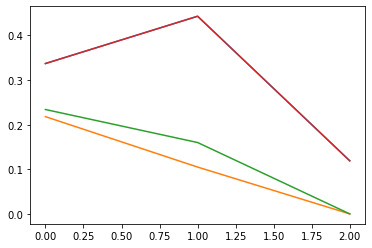

In [60]:
plt.plot(tc_table1.index, tc_table1['ssr F p-value'])
plt.plot(tc_table1.index, tc_table1['ssr chi2 p-value'])
plt.plot(tc_table1.index, tc_table1['likelihoodratio p-value'])
plt.plot(tc_table1.index, tc_table1['param F p-value'])

- Conclusion: The p-values for ssr based chi2 and likelihood ratio tests are significant, which indicates that the Sinophobic Twitter trend based may Granger cause Anti-Asian hate crimes at lag 3 based on ssr chi2 test and likelihood ratio test

In [17]:
tc_res2 = grangercausalitytests(np.column_stack((twitter_m_df, crime_diff)), maxlag=3)
tc_table2 = granger_table(tc_res2, 3)
tc_table2


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1389  , p=0.7204  , df_denom=7, df_num=1
ssr based chi2 test:   chi2=0.1984  , p=0.6560  , df=1
likelihood ratio test: chi2=0.1964  , p=0.6576  , df=1
parameter F test:         F=0.1389  , p=0.7204  , df_denom=7, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.9473  , p=0.2567  , df_denom=4, df_num=2
ssr based chi2 test:   chi2=8.7628  , p=0.0125  , df=2
likelihood ratio test: chi2=6.1189  , p=0.0469  , df=2
parameter F test:         F=1.9473  , p=0.2567  , df_denom=4, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1876  , p=0.5735  , df_denom=1, df_num=3
ssr based chi2 test:   chi2=28.5034 , p=0.0000  , df=3
likelihood ratio test: chi2=12.1437 , p=0.0069  , df=3
parameter F test:         F=1.1876  , p=0.5735  , df_denom=1, df_num=3


/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,


,Maxlags,ssr F p-value,ssr chi2 p-value,likelihoodratio p-value,param F p-value
0,1.0,0.72,0.656,0.658,0.72
1,2.0,0.257,0.013,0.047,0.257
2,3.0,0.574,0.0,0.007,0.574


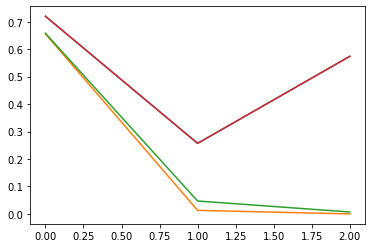

In [61]:
plt.plot(tc_table2.index, tc_table2['ssr F p-value'])
plt.plot(tc_table2.index, tc_table2['ssr chi2 p-value'])
plt.plot(tc_table2.index, tc_table2['likelihoodratio p-value'])
plt.plot(tc_table2.index, tc_table2['param F p-value'])

- Conclusion: We see that the p-values of ssr based chi2 test and likelihood ratio test are both significant at lag=2 and lag=3. This means that Sinophobic Twitter Post Trends Granger-causes the racial crimes based on these two tests.

In [18]:
ct_res1 = grangercausalitytests(np.column_stack((crime_a_diff, twitter_m_df)), maxlag=3)
ct_table1 = granger_table(ct_res1, 3)
ct_table1


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.6488  , p=0.0977  , df_denom=7, df_num=1
ssr based chi2 test:   chi2=5.2125  , p=0.0224  , df=1
likelihood ratio test: chi2=4.1953  , p=0.0405  , df=1
parameter F test:         F=3.6488  , p=0.0977  , df_denom=7, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1750  , p=0.3968  , df_denom=4, df_num=2
ssr based chi2 test:   chi2=5.2874  , p=0.0711  , df=2
likelihood ratio test: chi2=4.1594  , p=0.1250  , df=2
parameter F test:         F=1.1750  , p=0.3968  , df_denom=4, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.7551  , p=0.6668  , df_denom=1, df_num=3
ssr based chi2 test:   chi2=18.1229 , p=0.0004  , df=3
likelihood ratio test: chi2=9.4670  , p=0.0237  , df=3
parameter F test:         F=0.7551  , p=0.6668  , df_denom=1, df_num=3


/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,


,Maxlags,ssr F p-value,ssr chi2 p-value,likelihoodratio p-value,param F p-value
0,1.0,0.098,0.022,0.041,0.098
1,2.0,0.397,0.071,0.125,0.397
2,3.0,0.667,0.0,0.024,0.667


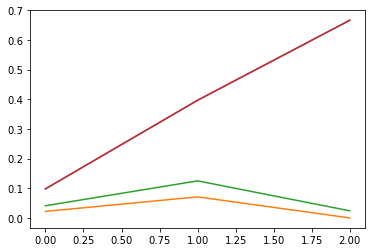

In [62]:
plt.plot(ct_table1.index, ct_table1['ssr F p-value'])
plt.plot(ct_table1.index, ct_table1['ssr chi2 p-value'])
plt.plot(ct_table1.index, ct_table1['likelihoodratio p-value'])
plt.plot(ct_table1.index, ct_table1['param F p-value'])

- Conslusion: At lag=1 and lag=2, the p-values of the ssr based chi test and likelihood ratio test are all significants, which means that occurrences of anti-Asian hate crimes Granger causes Sinophobic Twitter trends at lag 1 and 3. 

In [19]:
ct_res2 = grangercausalitytests(np.column_stack((crime_diff, twitter_m_df)), maxlag=3)
ct_table2 = granger_table(ct_res2, 3)
ct_table2


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0002  , p=0.9897  , df_denom=7, df_num=1
ssr based chi2 test:   chi2=0.0003  , p=0.9872  , df=1
likelihood ratio test: chi2=0.0003  , p=0.9872  , df=1
parameter F test:         F=0.0002  , p=0.9897  , df_denom=7, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2439  , p=0.7944  , df_denom=4, df_num=2
ssr based chi2 test:   chi2=1.0975  , p=0.5777  , df=2


/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,


likelihood ratio test: chi2=1.0356  , p=0.5958  , df=2
parameter F test:         F=0.2439  , p=0.7944  , df_denom=4, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5984  , p=0.5133  , df_denom=1, df_num=3
ssr based chi2 test:   chi2=38.3606 , p=0.0000  , df=3
likelihood ratio test: chi2=14.0561 , p=0.0028  , df=3
parameter F test:         F=1.5984  , p=0.5133  , df_denom=1, df_num=3


/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,


,Maxlags,ssr F p-value,ssr chi2 p-value,likelihoodratio p-value,param F p-value
0,1.0,0.99,0.987,0.987,0.99
1,2.0,0.794,0.578,0.596,0.794
2,3.0,0.513,0.0,0.003,0.513


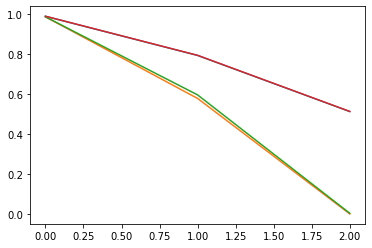

In [63]:
plt.plot(ct_table2.index, ct_table2['ssr F p-value'])
plt.plot(ct_table2.index, ct_table2['ssr chi2 p-value'])
plt.plot(ct_table2.index, ct_table2['likelihoodratio p-value'])
plt.plot(ct_table2.index, ct_table2['param F p-value'])

- Conclusion: The p-values for ssr based chi2 and likelihood tests are both significant at lag=3, indicating that general racial hate crimes Granger-cause Sinophobic Twitter trends at lag 3

## Granger Causality for Monthly Google Search Trend and Anti-Asian Hate Crimes Time Series

In [20]:
gc_res1 = grangercausalitytests(np.column_stack((google_m_old_df, crime_a_diff)), maxlag=3)
gc_table1 = granger_table(gc_res1, 3)
gc_table1


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1374  , p=0.7219  , df_denom=7, df_num=1
ssr based chi2 test:   chi2=0.1962  , p=0.6578  , df=1
likelihood ratio test: chi2=0.1943  , p=0.6593  , df=1
parameter F test:         F=0.1374  , p=0.7219  , df_denom=7, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.1052  , p=0.9025  , df_denom=4, df_num=2
ssr based chi2 test:   chi2=0.4734  , p=0.7892  , df=2
likelihood ratio test: chi2=0.4614  , p=0.7940  , df=2
parameter F test:         F=0.1052  , p=0.9025  , df_denom=4, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.3065  , p=0.8314  , df_denom=1, df_num=3
ssr based chi2 test:   chi2=7.3551  , p=0.0614  , df=3
likelihood ratio test: chi2=5.2160  , p=0.1566  , df=3
parameter F test:         F=0.3065  , p=0.8314  , df_denom=1, df_num=3


/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,


,Maxlags,ssr F p-value,ssr chi2 p-value,likelihoodratio p-value,param F p-value
0,1.0,0.722,0.658,0.659,0.722
1,2.0,0.903,0.789,0.794,0.903
2,3.0,0.831,0.061,0.157,0.831


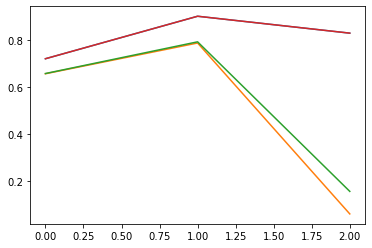

In [64]:
plt.plot(gc_table1.index, gc_table1['ssr F p-value'])
plt.plot(gc_table1.index, gc_table1['ssr chi2 p-value'])
plt.plot(gc_table1.index, gc_table1['likelihoodratio p-value'])
plt.plot(gc_table1.index, gc_table1['param F p-value'])

- Conclusion: From the above p-value table, we don't see Granger Causality between incidents of anti-Asian hate crimes and Google search trends of anti-Chinese words

In [21]:
gc_res2 = grangercausalitytests(np.column_stack((google_m_new_df, crime_a_diff)), maxlag=3)
gc_table2 = granger_table(gc_res2, 3)
gc_table2


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.2535  , p=0.2998  , df_denom=7, df_num=1
ssr based chi2 test:   chi2=1.7907  , p=0.1808  , df=1
likelihood ratio test: chi2=1.6473  , p=0.1993  , df=1
parameter F test:         F=1.2535  , p=0.2998  , df_denom=7, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.1123  , p=0.4130  , df_denom=4, df_num=2
ssr based chi2 test:   chi2=5.0051  , p=0.0819  , df=2
likelihood ratio test: chi2=3.9798  , p=0.1367  , df=2
parameter F test:         F=1.1123  , p=0.4130  , df_denom=4, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=7.6892  , p=0.2577  , df_denom=1, df_num=3
ssr based chi2 test:   chi2=184.5399, p=0.0000  , df=3
likelihood ratio test: chi2=25.4469 , p=0.0000  , df=3
parameter F test:         F=7.6892  , p=0.2577  , df_denom=1, df_num=3


/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,


,Maxlags,ssr F p-value,ssr chi2 p-value,likelihoodratio p-value,param F p-value
0,1.0,0.3,0.181,0.199,0.3
1,2.0,0.413,0.082,0.137,0.413
2,3.0,0.258,0.0,0.0,0.258


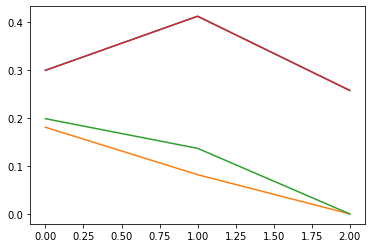

In [65]:
plt.plot(gc_table2.index, gc_table2['ssr F p-value'])
plt.plot(gc_table2.index, gc_table2['ssr chi2 p-value'])
plt.plot(gc_table2.index, gc_table2['likelihoodratio p-value'])
plt.plot(gc_table2.index, gc_table2['param F p-value'])

- Conclusion: At lag=3, ssr based test and likelihood test generate significant p-values, indicating a Granger Causality between Google search trends on the new set of anti-Chinese words and anti-Asian hate crimes

In [22]:
gc_res3 = grangercausalitytests(np.column_stack((google_m_old_df, crime_diff)), maxlag=3)
gc_table3 = granger_table(gc_res3, 3)
gc_table3


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.5525  , p=0.1541  , df_denom=7, df_num=1
ssr based chi2 test:   chi2=3.6465  , p=0.0562  , df=1
likelihood ratio test: chi2=3.1090  , p=0.0779  , df=1
parameter F test:         F=2.5525  , p=0.1541  , df_denom=7, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.3790  , p=0.1382  , df_denom=4, df_num=2
ssr based chi2 test:   chi2=15.2056 , p=0.0005  , df=2
likelihood ratio test: chi2=8.9042  , p=0.0117  , df=2
parameter F test:         F=3.3790  , p=0.1382  , df_denom=4, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1098.6313, p=0.0222  , df_denom=1, df_num=3
ssr based chi2 test:   chi2=26367.1508, p=0.0000  , df=3
likelihood ratio test: chi2=64.8059 , p=0.0000  , df=3
parameter F test:         F=1098.6313, p=0.0222  , df_denom=1, df_num=3


/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,


,Maxlags,ssr F p-value,ssr chi2 p-value,likelihoodratio p-value,param F p-value
0,1.0,0.154,0.056,0.078,0.154
1,2.0,0.138,0.0,0.012,0.138
2,3.0,0.022,0.0,0.0,0.022


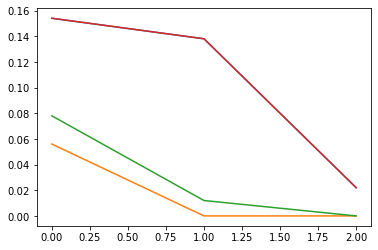

In [66]:
plt.plot(gc_table3.index, gc_table3['ssr F p-value'])
plt.plot(gc_table3.index, gc_table3['ssr chi2 p-value'])
plt.plot(gc_table3.index, gc_table3['likelihoodratio p-value'])
plt.plot(gc_table3.index, gc_table3['param F p-value'])

- Conclusion: So far this is the most significant Granger Causality result. At lag 2 and 3, almost all tests show a significant p-values for the Granger Causality, which means Google search trends based on the old set of search words Granger-cause all racial hate crimes.

In [23]:
gc_res4 = grangercausalitytests(np.column_stack((google_m_new_df, crime_diff)), maxlag=3)
gc_table4 = granger_table(gc_res4, 3)
gc_table4


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.1880  , p=0.0417  , df_denom=7, df_num=1
ssr based chi2 test:   chi2=8.8400  , p=0.0029  , df=1
likelihood ratio test: chi2=6.3340  , p=0.0118  , df=1
parameter F test:         F=6.1880  , p=0.0417  , df_denom=7, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.8669  , p=0.1689  , df_denom=4, df_num=2
ssr based chi2 test:   chi2=12.9009 , p=0.0016  , df=2
likelihood ratio test: chi2=8.0037  , p=0.0183  , df=2
parameter F test:         F=2.8669  , p=0.1689  , df_denom=4, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5146  , p=0.5240  , df_denom=1, df_num=3
ssr based chi2 test:   chi2=36.3503 , p=0.0000  , df=3
likelihood ratio test: chi2=13.7014 , p=0.0033  , df=3
parameter F test:         F=1.5146  , p=0.5240  , df_denom=1, df_num=3


/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,


,Maxlags,ssr F p-value,ssr chi2 p-value,likelihoodratio p-value,param F p-value
0,1.0,0.042,0.003,0.012,0.042
1,2.0,0.169,0.002,0.018,0.169
2,3.0,0.524,0.0,0.003,0.524


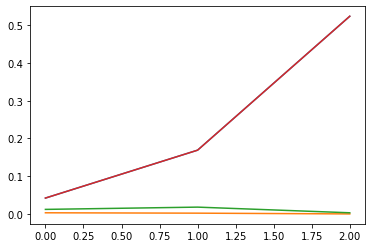

In [67]:
plt.plot(gc_table4.index, gc_table4['ssr F p-value'])
plt.plot(gc_table4.index, gc_table4['ssr chi2 p-value'])
plt.plot(gc_table4.index, gc_table4['likelihoodratio p-value'])
plt.plot(gc_table4.index, gc_table4['param F p-value'])

- Conclusion: In addition to the previous Granger Causality test being significant and salient, the Granger Causality between Google search trends of new set of anti-Chinese words and all racial hate crimes shows significant p values at lag=1,2,3. 

- Overall conclusion: The Google search trends based on the old and new set of anti-Chinese words Granger-cause racial hate crimes at a salient level.

Now let's move to the reverse direction

In [24]:
cg_res1 = grangercausalitytests(np.column_stack((crime_a_diff, google_m_old_df)), maxlag=3)
cg_table1 = granger_table(cg_res1, 3)
cg_table1


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7370  , p=0.4191  , df_denom=7, df_num=1
ssr based chi2 test:   chi2=1.0528  , p=0.3049  , df=1
likelihood ratio test: chi2=1.0010  , p=0.3171  , df=1
parameter F test:         F=0.7370  , p=0.4191  , df_denom=7, df_num=1

Granger Causality
number of lags (no zero) 2


/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,


ssr based F test:         F=0.5181  , p=0.6309  , df_denom=4, df_num=2
ssr based chi2 test:   chi2=2.3313  , p=0.3117  , df=2
likelihood ratio test: chi2=2.0731  , p=0.3547  , df=2
parameter F test:         F=0.5181  , p=0.6309  , df_denom=4, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1127  , p=0.9413  , df_denom=1, df_num=3
ssr based chi2 test:   chi2=2.7055  , p=0.4393  , df=3
likelihood ratio test: chi2=2.3306  , p=0.5067  , df=3
parameter F test:         F=0.1127  , p=0.9413  , df_denom=1, df_num=3


/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,


,Maxlags,ssr F p-value,ssr chi2 p-value,likelihoodratio p-value,param F p-value
0,1.0,0.419,0.305,0.317,0.419
1,2.0,0.631,0.312,0.355,0.631
2,3.0,0.941,0.439,0.507,0.941


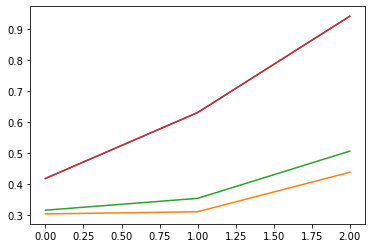

In [68]:
plt.plot(cg_table1.index, cg_table1['ssr F p-value'])
plt.plot(cg_table1.index, cg_table1['ssr chi2 p-value'])
plt.plot(cg_table1.index, cg_table1['likelihoodratio p-value'])
plt.plot(cg_table1.index, cg_table1['param F p-value'])

- Conclusion: We don't see a clear Granger Causality

In [25]:
cg_res2 = grangercausalitytests(np.column_stack((crime_a_diff, google_m_new_df)), maxlag=3)
cg_table2 = granger_table(cg_res2, 3)
cg_table2


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4798  , p=0.5108  , df_denom=7, df_num=1
ssr based chi2 test:   chi2=0.6854  , p=0.4077  , df=1
likelihood ratio test: chi2=0.6629  , p=0.4155  , df=1
parameter F test:         F=0.4798  , p=0.5108  , df_denom=7, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.7812  , p=0.1197  , df_denom=4, df_num=2
ssr based chi2 test:   chi2=17.0156 , p=0.0002  , df=2
likelihood ratio test: chi2=9.5532  , p=0.0084  , df=2
parameter F test:         F=3.7812  , p=0.1197  , df_denom=4, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6886  , p=0.3614  , df_denom=1, df_num=3
ssr based chi2 test:   chi2=88.5271 , p=0.0000  , df=3
likelihood ratio test: chi2=19.9231 , p=0.0002  , df=3
parameter F test:         F=3.6886  , p=0.3614  , df_denom=1, df_num=3


/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,


,Maxlags,ssr F p-value,ssr chi2 p-value,likelihoodratio p-value,param F p-value
0,1.0,0.511,0.408,0.416,0.511
1,2.0,0.12,0.0,0.008,0.12
2,3.0,0.361,0.0,0.0,0.361


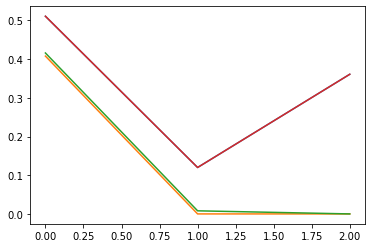

In [69]:
plt.plot(cg_table2.index, cg_table2['ssr F p-value'])
plt.plot(cg_table2.index, cg_table2['ssr chi2 p-value'])
plt.plot(cg_table2.index, cg_table2['likelihoodratio p-value'])
plt.plot(cg_table2.index, cg_table2['param F p-value'])

- Conclusion: At lag 2 and 3, the p-values based on ssr based chi2 and likelihood ratio tests are significant, which means incidents of anti-Asian hate crimes Granger-cause Google search trends based on the new set of anti-Chinese words

In [26]:
cg_res3 = grangercausalitytests(np.column_stack((crime_diff, google_m_old_df)), maxlag=3)
cg_table3 = granger_table(cg_res3, 3)
cg_table3


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4108  , p=0.5420  , df_denom=7, df_num=1
ssr based chi2 test:   chi2=0.5869  , p=0.4436  , df=1
likelihood ratio test: chi2=0.5703  , p=0.4501  , df=1
parameter F test:         F=0.4108  , p=0.5420  , df_denom=7, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0612  , p=0.9415  , df_denom=4, df_num=2
ssr based chi2 test:   chi2=0.2755  , p=0.8713  , df=2
likelihood ratio test: chi2=0.2713  , p=0.8731  , df=2
parameter F test:         F=0.0612  , p=0.9415  , df_denom=4, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1259  , p=0.9332  , df_denom=1, df_num=3
ssr based chi2 test:   chi2=3.0210  , p=0.3884  , df=3
likelihood ratio test: chi2=2.5629  , p=0.4640  , df=3
parameter F test:         F=0.1259  , p=0.9332  , df_denom=1, df_num=3


/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,


,Maxlags,ssr F p-value,ssr chi2 p-value,likelihoodratio p-value,param F p-value
0,1.0,0.542,0.444,0.45,0.542
1,2.0,0.941,0.871,0.873,0.941
2,3.0,0.933,0.388,0.464,0.933


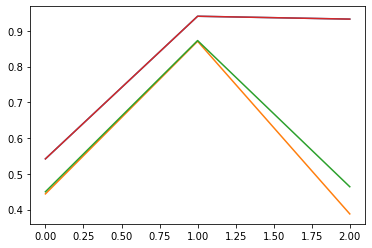

In [70]:
plt.plot(cg_table3.index, cg_table3['ssr F p-value'])
plt.plot(cg_table3.index, cg_table3['ssr chi2 p-value'])
plt.plot(cg_table3.index, cg_table3['likelihoodratio p-value'])
plt.plot(cg_table3.index, cg_table3['param F p-value'])

- Conclusion: We don't see Granger Causality between all racial hate crimes and Google search trends based on old set of anti-Chinese search terms

In [27]:
cg_res4 = grangercausalitytests(np.column_stack((crime_diff, google_m_new_df)), maxlag=3)
cg_table4 = granger_table(cg_res4, 3)
cg_table4


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0696  , p=0.3354  , df_denom=7, df_num=1
ssr based chi2 test:   chi2=1.5280  , p=0.2164  , df=1
likelihood ratio test: chi2=1.4220  , p=0.2331  , df=1
parameter F test:         F=1.0696  , p=0.3354  , df_denom=7, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7679  , p=0.2818  , df_denom=4, df_num=2
ssr based chi2 test:   chi2=7.9554  , p=0.0187  , df=2
likelihood ratio test: chi2=5.7003  , p=0.0578  , df=2
parameter F test:         F=1.7679  , p=0.2818  , df_denom=4, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=23.7816 , p=0.1493  , df_denom=1, df_num=3
ssr based chi2 test:   chi2=570.7585, p=0.0000  , df=3
likelihood ratio test: chi2=34.2515 , p=0.0000  , df=3
parameter F test:         F=23.7816 , p=0.1493  , df_denom=1, df_num=3


/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,
/var/folders/bz/72zd2hjs5t5drbxxvfh0xhph0000gn/T/ipykernel_3792/2581546275.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append({'Maxlags': lag,


,Maxlags,ssr F p-value,ssr chi2 p-value,likelihoodratio p-value,param F p-value
0,1.0,0.335,0.216,0.233,0.335
1,2.0,0.282,0.019,0.058,0.282
2,3.0,0.149,0.0,0.0,0.149


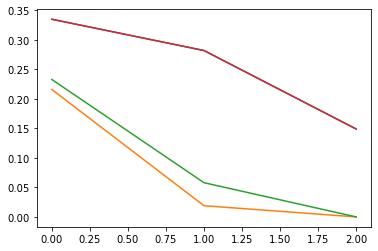

In [71]:
plt.plot(cg_table4.index, cg_table4['ssr F p-value'])
plt.plot(cg_table4.index, cg_table4['ssr chi2 p-value'])
plt.plot(cg_table4.index, cg_table4['likelihoodratio p-value'])
plt.plot(cg_table4.index, cg_table4['param F p-value'])

- Conclusion: We see significant p-values on ssr based chi2 test and likelihood ratio test at lag=2 and lag=3, indicating that incidents of all racial hate crimes Granger-cause Google search on the new set of anti-Chinese terms

In [39]:
example = pd.concat([tgm_table1, tgm_table2, gtm_table1, gtm_table2, 
                              tc_table1, tc_table2, ct_table1, ct_table2, gc_table1, 
                              gc_table2, gc_table3, gc_table4, cg_table1, cg_table2, 
                              cg_table3, cg_table4])
example

,Maxlags,ssr F p-value,ssr chi2 p-value,likelihoodratio p-value,param F p-value
0,1.0,0.147,0.052,0.073,0.147
1,2.0,0.712,0.434,0.465,0.712
2,3.0,0.583,0.0,0.008,0.583
0,1.0,0.307,0.188,0.206,0.307
1,2.0,0.43,0.094,0.15,0.43
2,3.0,0.289,0.0,0.0,0.289
0,1.0,0.938,0.923,0.923,0.938
1,2.0,0.851,0.686,0.696,0.851
2,3.0,0.823,0.051,0.143,0.823
0,1.0,0.646,0.566,0.569,0.646


In [45]:
row1 = ['twitter, google search on old words'] + ['']*4
row1 = pd.DataFrame([row1], columns=['Maxlags', 'ssr F p-value', 'ssr chi2 p-value', 'likelihoodratio p-value', 'param F p-value'])

row2 = ['twitter, google search on new words'] + ['']*4
row2 = pd.DataFrame([row2], columns=['Maxlags', 'ssr F p-value', 'ssr chi2 p-value', 'likelihoodratio p-value', 'param F p-value'])

row3 = ['google search on old words, twitter'] + ['']*4
row3 = pd.DataFrame([row3], columns=['Maxlags', 'ssr F p-value', 'ssr chi2 p-value', 'likelihoodratio p-value', 'param F p-value'])

row4 = ['google search on new words, twitter'] + ['']*4
row4 = pd.DataFrame([row4], columns=['Maxlags', 'ssr F p-value', 'ssr chi2 p-value', 'likelihoodratio p-value', 'param F p-value'])

row5 = ['twitter, anti-Asian crimes'] + ['']*4
row5 = pd.DataFrame([row5], columns=['Maxlags', 'ssr F p-value', 'ssr chi2 p-value', 'likelihoodratio p-value', 'param F p-value'])

row6 = ['twitter, all-racial crimes'] + ['']*4
row6 = pd.DataFrame([row6], columns=['Maxlags', 'ssr F p-value', 'ssr chi2 p-value', 'likelihoodratio p-value', 'param F p-value'])

row7 = ['anti-Asian crimes, twitter'] + ['']*4
row7 = pd.DataFrame([row7], columns=['Maxlags', 'ssr F p-value', 'ssr chi2 p-value', 'likelihoodratio p-value', 'param F p-value'])

row8 = ['all-racial crimes, twitter'] + ['']*4
row8 = pd.DataFrame([row8], columns=['Maxlags', 'ssr F p-value', 'ssr chi2 p-value', 'likelihoodratio p-value', 'param F p-value'])

row9 = ['google search on old words, anti-Asian crimes'] + ['']*4
row9 = pd.DataFrame([row9], columns=['Maxlags', 'ssr F p-value', 'ssr chi2 p-value', 'likelihoodratio p-value', 'param F p-value'])

row10 = ['google search on new words, anti-Asian crimes'] + ['']*4
row10 = pd.DataFrame([row10], columns=['Maxlags', 'ssr F p-value', 'ssr chi2 p-value', 'likelihoodratio p-value', 'param F p-value'])

row11 = ['google search on old words, all-racial crimes'] + ['']*4
row11 = pd.DataFrame([row11], columns=['Maxlags', 'ssr F p-value', 'ssr chi2 p-value', 'likelihoodratio p-value', 'param F p-value'])

row12 = ['google search on new words, all-racial crimes'] + ['']*4
row12 = pd.DataFrame([row12], columns=['Maxlags', 'ssr F p-value', 'ssr chi2 p-value', 'likelihoodratio p-value', 'param F p-value'])

row13 = ['google search on old words, anti-Asian crimes'] + ['']*4
row13 = pd.DataFrame([row13], columns=['Maxlags', 'ssr F p-value', 'ssr chi2 p-value', 'likelihoodratio p-value', 'param F p-value'])

row14 = ['google search on new words, anti-Asian crimes'] + ['']*4
row14 = pd.DataFrame([row14], columns=['Maxlags', 'ssr F p-value', 'ssr chi2 p-value', 'likelihoodratio p-value', 'param F p-value'])

row15 = ['google search on old words, all-racial crimes'] + ['']*4
row15 = pd.DataFrame([row15], columns=['Maxlags', 'ssr F p-value', 'ssr chi2 p-value', 'likelihoodratio p-value', 'param F p-value'])

row16 = ['google search on new words, all-racial crimes'] + ['']*4
row16 = pd.DataFrame([row16], columns=['Maxlags', 'ssr F p-value', 'ssr chi2 p-value', 'likelihoodratio p-value', 'param F p-value'])


In [44]:
df_row1 = pd.DataFrame([row1], columns=['Maxlags', 'ssr F p-value', 'ssr chi2 p-value', 'likelihoodratio p-value', 'param F p-value'])
exa = pd.concat([df_row1, tgm_table1, tgm_table1])
exa

,Maxlags,ssr F p-value,ssr chi2 p-value,likelihoodratio p-value,param F p-value
0,"twitter, google search on old words",,,,
0,1.0,0.147,0.052,0.073,0.147
1,2.0,0.712,0.434,0.465,0.712
2,3.0,0.583,0.0,0.008,0.583
0,1.0,0.147,0.052,0.073,0.147
1,2.0,0.712,0.434,0.465,0.712
2,3.0,0.583,0.0,0.008,0.583


In [49]:
monthly_p_values = pd.concat([row1, tgm_table1, row2, tgm_table2, row3, gtm_table1, row4, gtm_table2, 
                              row5, tc_table1, row6, tc_table2, row7, ct_table1, row8, ct_table2, row9, gc_table1, 
                              row10, gc_table2, row11, gc_table3, row12, gc_table4, row13, cg_table1, row14, cg_table2, 
                              row15, cg_table3, row16, cg_table4])

monthly_p_values = monthly_p_values.reset_index(drop=True)
monthly_p_values

,Maxlags,ssr F p-value,ssr chi2 p-value,likelihoodratio p-value,param F p-value
0,"twitter, google search on old words",,,,
1,1.0,0.147,0.052,0.073,0.147
2,2.0,0.712,0.434,0.465,0.712
3,3.0,0.583,0.0,0.008,0.583
4,"twitter, google search on new words",,,,
...,...,...,...,...,...
59,3.0,0.933,0.388,0.464,0.933
60,"google search on new words, all-racial crimes",,,,
61,1.0,0.335,0.216,0.233,0.335
62,2.0,0.282,0.019,0.058,0.282


In [50]:
monthly_p_values.to_csv('Granger_Monthly_Results.csv')